# Prediction Analysis from Behavioral data

*Note:* Use local SLEAP's env

### Installing required packages

In [1]:
# !pip install h5py
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install sklearn
# !pip install numpy
# !pip install scipy
# !pip install sleap==1.2.6
# !pip install tables

### Importing packages

In [2]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy.interpolate import interp1d

### Getting the data from Github (If you are using Colab)

In [3]:
# !wget -O prediction_analysis.h5 https://github.com/rdiazrincon/SLEAP_Data/blob/master/displacement_analysis/data/prediction_analysis.h5

### Gettting the data directly from the path

In [4]:
path = "data/prediction_analysis.h5"
intervals = "data/WL_info_by_timestamp.csv"

## Exploring the data

In [5]:
# Opening H5 file
with h5py.File(path, "r") as f:
    dataset_keys = list(f.keys())
    tracks = f["tracks"][:].T
    bodyparts = [n.decode() for n in f["node_names"][:]]

print("Filename: " + path)
print("Array keys: " + str(dataset_keys))
print("Behavioral data shape: " + str(tracks.shape))
print("Body parts: " + str(bodyparts))

Filename: data/prediction_analysis.h5
Array keys: ['edge_inds', 'edge_names', 'instance_scores', 'node_names', 'point_scores', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks']
Behavioral data shape: (54546, 6, 2, 2)
Body parts: ['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']


Keys shape

“track_occupancy” (shape: tracks * frames)

“tracks” (shape: frames * nodes * 2 * tracks)

“track_names” (shape: tracks)

“bodyparts” (shape: nodes)

“edge_names” (shape: nodes - 1)

“edge_inds” (shape: nodes - 1)

“point_scores” (shape: frames * nodes * tracks)

“instance_scores” (shape: frames * tracks)

“tracking_scores” (shape: frames * tracks)

## Understanding the data 

We will mostly work with the tracks array. It contains information regarding Number of Frames, Number of Bodyparts, Number of Coordinates and Number of instances.


In [6]:
# Here's what each dimension of the matrix means
n_frames, n_bodyparts, n_coordinates, n_instances = tracks.shape

print("Number of Frames:", n_frames)
print("Number of Bodyparts:", n_bodyparts)
print("Number of Coordinates", n_coordinates)
print("NUmber of Instances:", n_instances)

Number of Frames: 54546
Number of Bodyparts: 6
Number of Coordinates 2
NUmber of Instances: 2


### Lets take a look at the data

#### First frame 

In [7]:
print(tracks[0])

[[[184.44789124 315.60144043]
  [351.55776978 379.87524414]]

 [[140.21481323 284.03588867]
  [364.47213745 367.95025635]]

 [[183.75314331 319.75219727]
  [404.18869019 427.59402466]]

 [[147.53791809 412.41549683]
  [208.04371643 216.35691833]]

 [[148.6204834  339.65484619]
  [324.4312439  299.75323486]]

 [[168.43464661 296.26281738]
  [367.9828186  387.65563965]]]


#### Forehead coordinates for both mouse in Frame 1

In [8]:
print(tracks[0][5])

[[168.43464661 296.26281738]
 [367.9828186  387.65563965]]


#### X-Forehead coordinate for both mouse in Frame 1

In [9]:
print(tracks[0][5][0])

[168.43464661 296.26281738]


#### X-Forehead coordinate for mouse 2 in Frame 1.

In [10]:
print(tracks[0][5][0][1]) 

296.2628173828125


Now that we've loaded the data, let's see some different things we can do with it...

## Fill missing values

We won't drop the NaN values but will fill them with Non Zero values so the analysis is easier to make

In [11]:
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [12]:
tracks = fill_missing(tracks)
print(tracks.shape)


(54546, 6, 2, 2)


In [13]:
df = pd.DataFrame(np.array(h5py.File(path)['track_occupancy']))
# df = pd.DataFrame(np.array(tracks[555][0]))
df

,0,1
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
54541,1,1
54542,1,1
54543,1,1
54544,1,1


In [110]:
trials_array = [trial.split("-") for trial in trials_array]
bla = []
for i in range(len(trials_array)):
    for j in trials_array[i]:
        bla.append(eval(j))
        # print(j)
# trials_array = [eval(item) for item in trials_array]
# print(bla)

## Visualize nose movement across whole video video

In progress: Identify which frame corresponds to which minute/second of the video and analyze those chunks separately

In [244]:
LEFT_EAR_INDEX = 0
RIGHT_EAR_INDEX = 1
NOSE_INDEX = 2
TAIL_BASE_INDEX = 3
THORAX_INDEX = 4
FOREHEAD_INDEX = 5
left_ear_loc = []

do = iter(bla)
# for x in range
for i, j in zip(do, do):
    # print(i, j)
    left_ear_loc.append(tracks[i:j, LEFT_EAR_INDEX, :, :])

boyo = np.asarray(left_ear_loc)
boyo = boyo.reshape(6000, 2, 2)
print(boyo.shape)
    # left_ear_loc = tracks[bla[i]:bla[i+1] , LEFT_EAR_INDEX, :, :]
    
# print(left_ear_loc[0][3][])

# left_ear_loc = tracks[bla[4]:bla[5] , LEFT_EAR_INDEX, :, :]
# print(len(left_ear_loc))
# print(len(tracks[bla[2]:bla[3]]))
# left_ear_loc = tracks[:, LEFT_EAR_INDEX, :, :]
right_ear_loc = tracks[:, RIGHT_EAR_INDEX, :, :]
print(right_ear_loc.shape)
nose_loc = tracks[:, NOSE_INDEX, :, :]
tail_base_loc = tracks[:, TAIL_BASE_INDEX, :, :]
thorax_loc = tracks[:, THORAX_INDEX, :, :]
forehead_loc = tracks[:, FOREHEAD_INDEX, :, :]

(6000, 2, 2)
(54546, 2, 2)


### Converting our data into a Tabular format

In [245]:
# There is an easier way of doing this but I don't have the time now

df = pd.DataFrame({
    'm1_left_ear_x': boyo[:, 0, 0], 
    'm1_left_ear_y': boyo[:, 1, 0], 
    "m2_left_ear_x": boyo[:, 0, 1],
    "m2_left_ear_y": boyo[:, 1, 1],

    # 'm1_right_ear_x': right_ear_loc[:, 0, 0], 
    # 'm1_right_ear_y': right_ear_loc[:, 1, 0], 
    # "m2_right_ear_x": right_ear_loc[:, 0, 1],
    # "m2_right_ear_y": right_ear_loc[:, 1, 1],
    
    # 'm1_nose_x': nose_loc[:, 0, 0], 
    # 'm1_nose_y': nose_loc[:, 1, 0], 
    # "m2_nose_x": nose_loc[:, 0, 1],
    # "m2_nose_y": nose_loc[:, 1, 1],

    # 'm1_tail_base_x': tail_base_loc[:, 0, 0], 
    # 'm1_tail_base_y': tail_base_loc[:, 1, 0], 
    # "m2_tail_base_x": tail_base_loc[:, 0, 1],
    # "m2_tail_base_y": tail_base_loc[:, 1, 1],

    # 'm1_thorax_x': thorax_loc[:, 0, 0], 
    # 'm1_thorax_y': thorax_loc[:, 1, 0], 
    # "m2_thorax_x": thorax_loc[:, 0, 1],
    # "m2_thorax_y": thorax_loc[:, 1, 1],

    # 'm1_forehead_x': forehead_loc[:, 0, 0], 
    # 'm1_forehead_y': forehead_loc[:, 1, 0], 
    # "m2_forehead_x": forehead_loc[:, 0, 1],
    # "m2_forehead_y": forehead_loc[:, 1, 1],
    })
df

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y
0,435.738861,352.499847,323.723297,383.477448
1,435.784668,352.405945,323.433044,380.188843
2,432.359528,352.400665,323.640228,380.157562
3,432.411316,352.264740,323.588898,380.525604
4,435.479797,352.146271,323.533112,383.891266
...,...,...,...,...
5995,324.019257,380.543854,236.562531,372.530457
5996,324.042328,380.474396,239.551392,372.427856
5997,323.935272,380.598358,239.575912,372.512695
5998,323.913208,383.466827,239.627777,372.315765


In [17]:
type(df)

pandas.core.frame.DataFrame

### Further exploration of the data

In [18]:
df.describe()

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
count,54546.000000,54546.000000,54546.000000,54546.000000,54546.000000,54546.000000,54546.000000,54546.000000,54546.000000,54546.000000,...,54546.000000,54546.000000,54546.000000,54546.000000,54546.000000,54546.000000,54546.000000,54546.000000,54546.000000,54546.000000
mean,322.163993,347.657266,316.570108,343.826404,288.110561,348.149955,283.510898,345.210286,313.108194,380.850327,...,273.007424,236.937731,298.145584,305.814272,291.119960,304.072151,306.617372,357.557091,301.707745,353.674454
std,89.776575,69.348560,105.424562,63.045516,91.968948,68.893609,106.363852,63.356571,84.760004,78.938631,...,121.512036,40.696641,95.850158,51.654599,111.019108,46.034715,89.401707,70.201011,103.837788,64.190737
min,6.150162,6.844583,5.117293,7.057106,5.575805,8.227011,5.385733,8.199083,5.701965,8.362377,...,7.722121,23.840078,7.304730,32.087944,6.840467,43.809231,5.489769,7.095680,5.283314,6.870908
25%,303.977805,336.153542,259.869217,331.839615,271.815805,347.657745,228.378841,335.709305,300.098030,372.174164,...,179.703217,212.014618,251.987915,299.797852,224.216530,288.326469,291.801285,352.073463,251.638084,343.699677
50%,323.710129,372.127182,320.476151,363.702881,283.642273,368.358109,280.310287,364.161789,308.306976,416.271164,...,255.747711,233.655309,296.380875,320.327469,288.544907,316.326752,303.449600,384.359161,300.332031,375.892776
75%,332.025063,387.599792,340.199104,380.556793,292.334892,379.769539,300.031113,376.503365,327.847443,423.741730,...,352.559952,259.708084,327.560143,331.924484,331.409698,328.525581,315.968864,395.631668,323.580574,391.940544
max,628.218628,443.329468,628.762451,436.115326,630.346130,448.224274,630.401184,448.298676,631.520691,468.526306,...,591.489807,383.469147,612.270691,407.772522,616.321838,415.695221,629.592590,436.267120,630.424438,443.891205


In [19]:
df.sample()

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
43753,224.303864,344.062256,323.418121,387.573883,183.565125,380.471649,280.444214,372.128052,256.327515,392.559967,...,271.795044,236.229935,179.778458,319.924988,299.762726,332.112274,212.414337,371.911377,300.100494,395.662292


In [20]:
df.value_counts()

m1_left_ear_x  m1_left_ear_y  m2_left_ear_x  m2_left_ear_y  m1_right_ear_x  m1_right_ear_y  m2_right_ear_x  m2_right_ear_y  m1_nose_x   m1_nose_y   m2_nose_x   m2_nose_y   m1_tail_base_x  m1_tail_base_y  m2_tail_base_x  m2_tail_base_y  m1_thorax_x  m1_thorax_y  m2_thorax_x  m2_thorax_y  m1_forehead_x  m1_forehead_y  m2_forehead_x  m2_forehead_y
6.150162       60.109028      315.901184     383.530914     47.948474       52.455449       279.540497      371.887177      36.650353   36.284746   315.628632  424.613098  59.942154       155.683792      280.486145      212.387497      36.097183    79.653488    299.781555   324.155579   29.551253      51.140123      296.244202     392.067413       1
327.586273     360.053741     304.127167     315.630859     287.961578      388.655640      214.778616      385.394442      327.906433  416.310944  279.056488  401.729828  191.810059      215.540833      332.230530      207.648590      267.476562   323.794525   304.147797   267.926636   316.039154   

In [21]:
df2 = pd.DataFrame(np.array(np.random.randint(2, size=54546)), columns=['Features'])
df2

,Features
0,1
1,1
2,1
3,0
4,1
...,...
54541,0
54542,1
54543,1
54544,1


### Running Random Forest for prediction

In [22]:
X = df
Y = df2

In [23]:
X.shape

(54546, 24)

In [24]:
Y.shape

(54546, 1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [26]:
model = RandomForestClassifier(n_estimators = 10, random_state = 30)

In [27]:
model.fit(X_train, y_train)

/tmp/ipykernel_1877/180087699.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=10, random_state=30)

In [28]:
prediction_test = model.predict(X_test)
prediction_test

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
prediction_probability = model.predict_proba(X_test)
prediction_probability

array([[0.6, 0.4],
       [0.5, 0.5],
       [0.8, 0.2],
       ...,
       [0.8, 0.2],
       [0.6, 0.4],
       [0.7, 0.3]])

In [30]:
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))

Accuracy =  0.5023831347387717


In [31]:
print(model.score(X_test, y_test))

0.5023831347387717


In [32]:
df3 = pd.DataFrame(np.array(prediction_test), columns=["Predicted class labels"])
df3

,Predicted class labels
0,0
1,0
2,0
3,1
4,1
...,...
10905,0
10906,0
10907,0
10908,0


In [33]:
df4 = pd.DataFrame(np.array(y_test), columns=["Actual class labels"])
df4

,Actual class labels
0,1
1,1
2,0
3,0
4,0
...,...
10905,1
10906,0
10907,0
10908,1


In [34]:
feature_list = list(X.columns)
feature_list

['m1_left_ear_x',
 'm1_left_ear_y',
 'm2_left_ear_x',
 'm2_left_ear_y',
 'm1_right_ear_x',
 'm1_right_ear_y',
 'm2_right_ear_x',
 'm2_right_ear_y',
 'm1_nose_x',
 'm1_nose_y',
 'm2_nose_x',
 'm2_nose_y',
 'm1_tail_base_x',
 'm1_tail_base_y',
 'm2_tail_base_x',
 'm2_tail_base_y',
 'm1_thorax_x',
 'm1_thorax_y',
 'm2_thorax_x',
 'm2_thorax_y',
 'm1_forehead_x',
 'm1_forehead_y',
 'm2_forehead_x',
 'm2_forehead_y']

In [35]:
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp

m2_nose_y         0.045305
m1_nose_y         0.044353
m2_tail_base_y    0.042982
m1_forehead_y     0.042871
m1_left_ear_y     0.042575
m2_forehead_y     0.042322
m1_tail_base_y    0.042318
m1_tail_base_x    0.042271
m2_left_ear_y     0.042181
m2_right_ear_y    0.041893
m1_right_ear_y    0.041821
m1_right_ear_x    0.041699
m1_forehead_x     0.041628
m1_thorax_y       0.041577
m1_nose_x         0.041530
m2_nose_x         0.041407
m2_thorax_y       0.041370
m2_tail_base_x    0.041111
m1_left_ear_x     0.041103
m2_left_ear_x     0.041038
m1_thorax_x       0.040177
m2_thorax_x       0.039242
m2_right_ear_x    0.038978
m2_forehead_x     0.038250
dtype: float64

In [36]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

Text(0.5, 1.0, 'Nose tracks across frames')

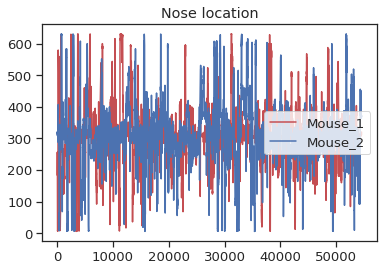

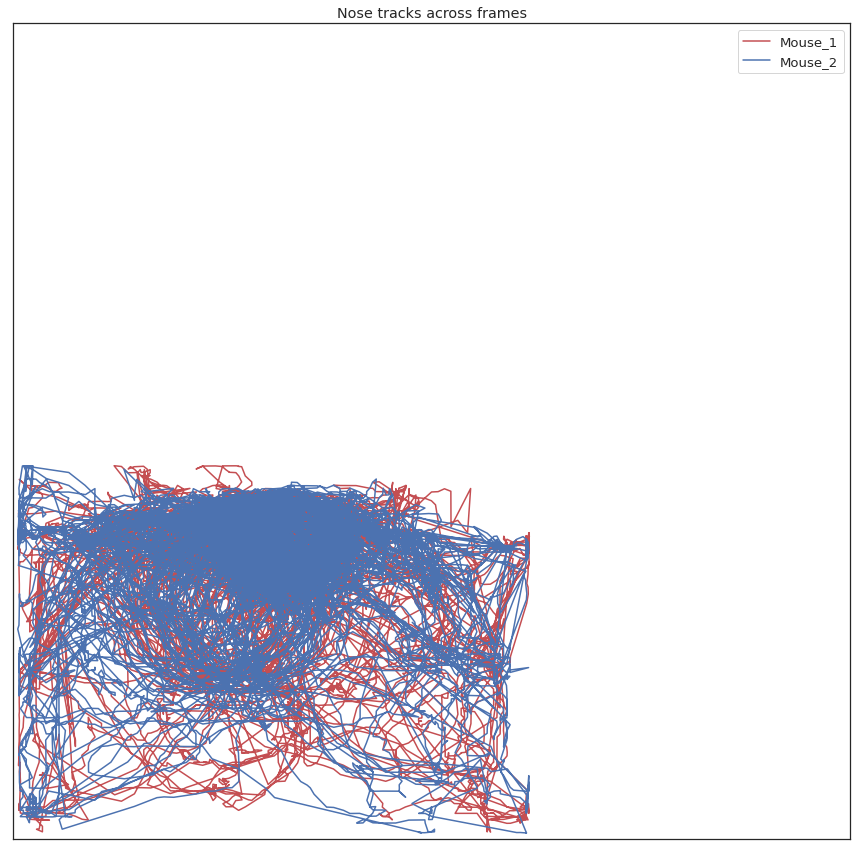

In [37]:
# Figure 1
plt.figure()

plt.plot(nose_loc[:,0,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1], 'b',label='Mouse_2')
# plt.plot(-1*nose_loc[:,1,0], 'r')
# plt.plot(-1*nose_loc[:,1,1], 'b')

plt.legend(loc="center right")

plt.title('Nose location')

# Figure 2
plt.figure(figsize=(15,15))

plt.plot(nose_loc[:,0,0],nose_loc[:,1,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1],nose_loc[:,1,1], 'b',label='Mouse_2')
plt.legend()

plt.xlim(0,1024)
plt.xticks([])

plt.ylim(0,1024)
plt.yticks([])
plt.title('Nose tracks across frames')

## More advanced visualizations (In Progress)

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

In [38]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

There are two mice. Let's get results for each separately.

In [39]:
thx_vel_mouse1 = smooth_diff(thorax_loc[:, :, 0])
thx_vel_mouse2 = smooth_diff(thorax_loc[:, :, 1])

### Visualizing thorax x-y dynamics and velocity for Mouse_1

Text(0.5, 1.0, 'Velocity')

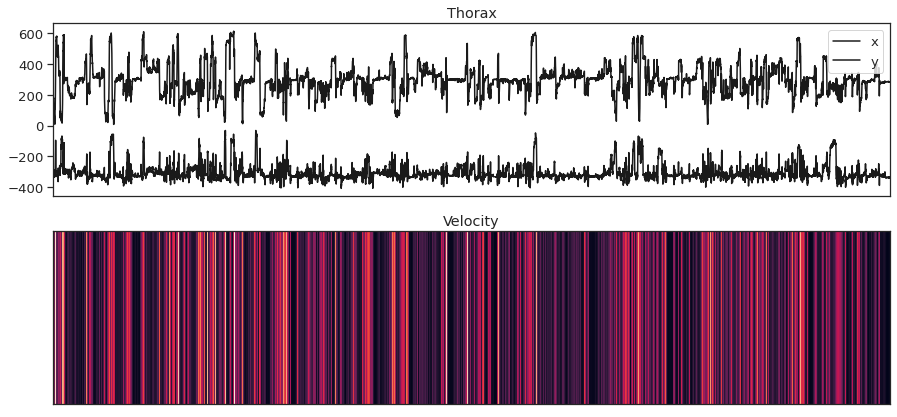

In [40]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
# Using the Transpose of the Matrix
ax2.imshow(thx_vel_mouse1[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

### Visualize thorax colored by magnitude of Mouse speed

Text(0.5, 1.0, 'Thorax tracks colored by magnitude of Mouse speed')

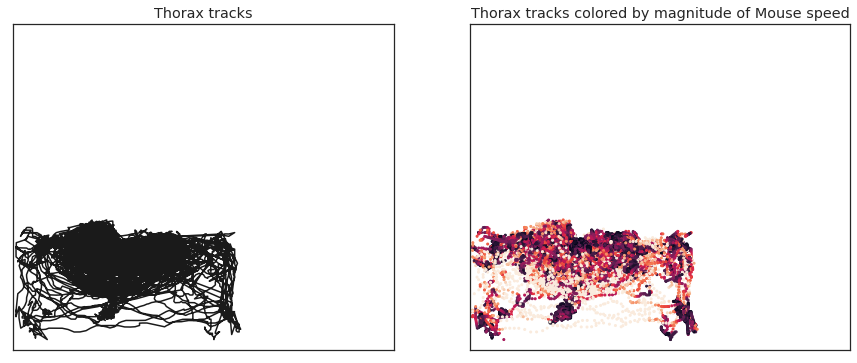

In [41]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_mouse1 
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,0], thorax_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of Mouse speed')

### Find covariance in thorax velocities between Mouse_1 and Mouse_2

In [42]:
def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between
    
    win sets the number of frames over which the covariance is computed
    
    """
    
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    
    return np.array(s2.rolling(win).corr(s1))

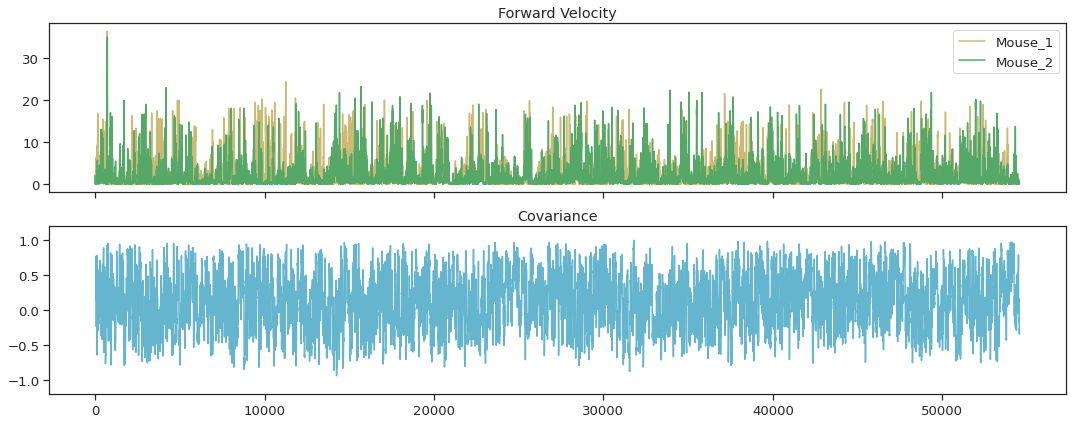

In [43]:
win = 50

cov_vel = corr_roll(thx_vel_mouse1, thx_vel_mouse2,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(thx_vel_mouse1, 'y', label='Mouse_1')
ax[0].plot(thx_vel_mouse2, 'g', label='Mouse_2')
ax[0].legend()
ax[0].set_title('Forward Velocity')

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

### Todo:
- Use frame rate (30) to correlate have an intuition of which set of frames correspond to which minute/second in the video

## Clustering

For an example of clustering the data, we'll

1. extract joint velocities for each joint,
2. run k-means on the velocities from each frame.


In [44]:
def instance_node_velocities(instance_idx):
    mouse_node_tracks = tracks[:, :, :, instance_idx]
    mouse_node_velocities = np.zeros((n_frames, n_bodyparts))

    for n in range(0, n_bodyparts):
        mouse_node_velocities[:, n] = smooth_diff(mouse_node_tracks[:, n, :])
    
    return mouse_node_velocities

In [45]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(n_bodyparts), bodyparts, rotation=20);
    plt.title(f'Mouse {instance_idx} node velocities')

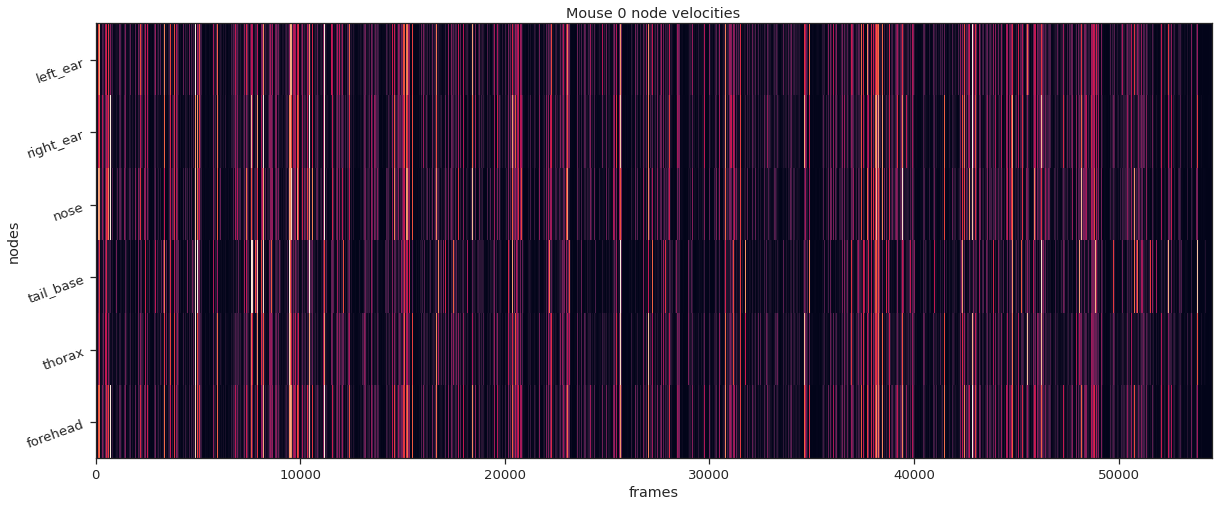

In [46]:
mouse_ID = 0
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

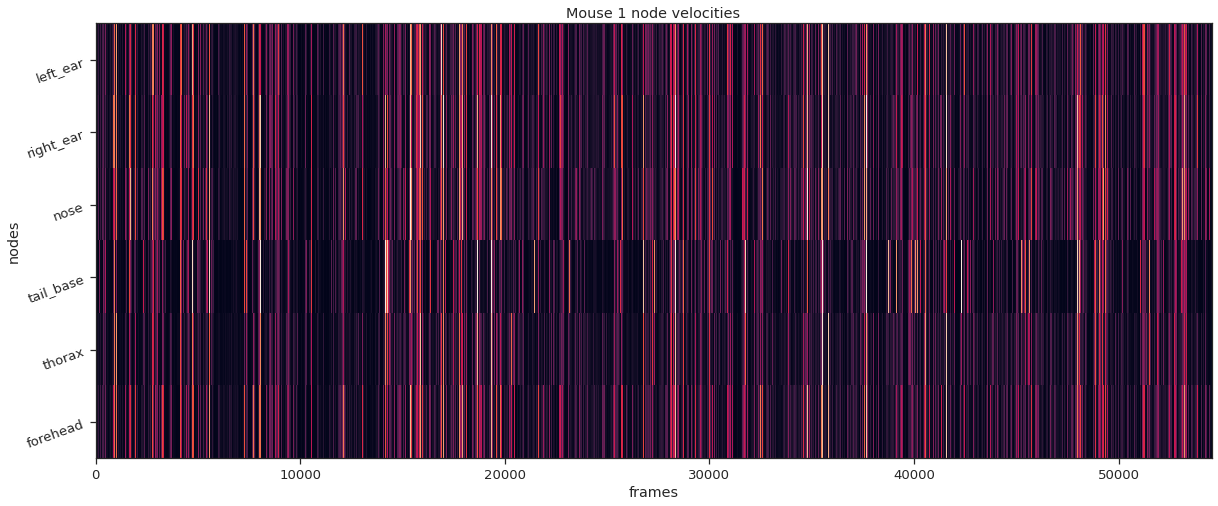

In [47]:
mouse_ID = 1
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

In [48]:
from sklearn.cluster import KMeans

In [49]:
nstates = 10

km = KMeans(n_clusters=nstates)

labels = km.fit_predict(mouse_node_velocities)

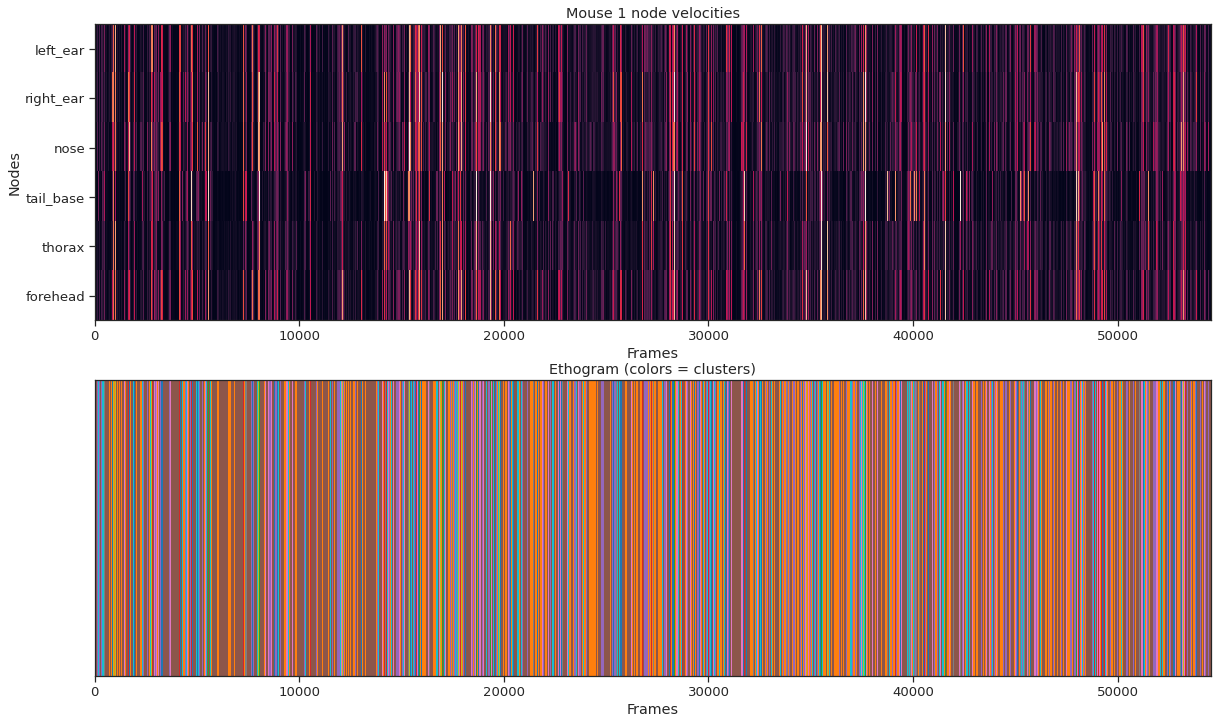

In [50]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(mouse_node_velocities.T, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(n_bodyparts))
ax1.set_yticklabels(bodyparts);
ax1.set_title(f"Mouse {mouse_ID} node velocities")
ax1.set_xlim(0,n_frames)

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");